## Problem Statement
### Once books pass their release windows, they tend to fall off the radar of book readers unless the author releases a new book.  What is good way to recommend old and new books to people. 

## Prospective Clients
### •	Book Retailers - The most obvious potential beneficiaries, book retailers, online or terrestrial,  could utilize this analysis to optimize multiple aspects of its strategy, from where to place certain products in the store, when to make changes, which marketing strategies are most effective, and which customer cohorts are most profitable. 
### •	Book Publishers – This information can be used to better identify the demographic breakdown of each book genre reader. 
### •	Authors – This information will allow them to get a better idea of the demand for various types of book genres.

## Approach
### Description of specific models to be used will be refined as I progress through this project. I will use deep learning, TensorFlow and Keras to build a recommendation model.

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import glob
os.getcwd()
%matplotlib inline

In [2]:
#data prep and model evaluation

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
import lightgbm as lgb

In [3]:
#TensorFlow and Keras

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


## I am adding the three csv files

In [4]:
ratings = pd.read_csv("C:/Users/Rob's Surface/Desktop/BX/BX-Book-Ratings.csv", error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')
books = pd.read_csv("C:/Users/Rob's Surface/Desktop/BX/BX-Books.csv", error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')
users = pd.read_csv("C:/Users/Rob's Surface/Desktop/BX/BX-Users.csv", error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.p

## Here I merge the three files into one document

In [5]:
data = pd.merge(ratings, users, on='User-ID', how='inner')

In [6]:
data = pd.merge(data, books, on='ISBN', how='inner')

## Here let us explore the data

In [7]:
data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Location', 'Age', 'Book-Title',
       'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S',
       'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [8]:
data.shape

(1031136, 12)

In [9]:
data.head(5)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


## I dropped the colums with the picture links

In [10]:
no_pic = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L']

data = data.drop(no_pic, axis=1, inplace=False)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  int64  
 3   Location             1031136 non-null  object 
 4   Age                  753301 non-null   float64
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031135 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 78.7+ MB


## Next I changed the data types to allow them to be used in my model 

In [23]:
data['User-ID'] = data['User-ID'].astype(str).astype(int)
data['ISBN'] = data['ISBN'].astype(str)
data['Book-Rating'] = data['Book-Rating'].astype(str).astype(float)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int32  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  float64
 3   Location             1031136 non-null  object 
 4   Age                  753301 non-null   float64
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031135 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
dtypes: float64(2), int32(1), object(6)
memory usage: 74.7+ MB


## More data exploring and cleaning

### Age is very skewed and needs to be normalized

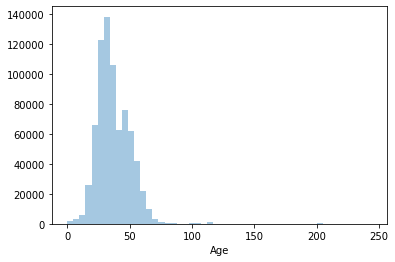

In [25]:
sns.distplot(data['Age'].dropna(), kde=False);

## To normalize the average book rating I will replace 0 with none

In [12]:
data['Book-Rating'] = data['Book-Rating'].replace(0, None)

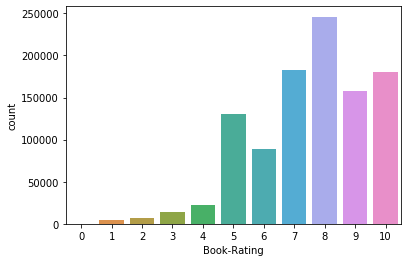

In [13]:
sns.countplot(x='Book-Rating', data=data);

In [14]:
print('Average book rating: ', round(data['Book-Rating'].mean(), 2))

Average book rating:  7.55


## Book orgin grouped by country

In [15]:
country = data['Location'].apply(lambda row: str(row).split(',')[-1])
data.groupby(country)['Book-Rating'].count().sort_values(ascending=False).head(10)

Location
 usa               746466
 canada             93000
 united kingdom     33072
 germany            27657
                    24259
 australia          18238
 spain              14968
 n/a                11177
 france             10639
 portugal            6980
Name: Book-Rating, dtype: int64

##  The year column covers a wide but has very few entries for some years

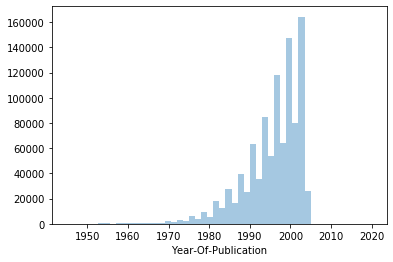

In [29]:
year = pd.to_numeric(data['Year-Of-Publication'], errors='coerce').fillna(2099, downcast = 'infer')
sns.distplot(year, kde=False, hist_kws={"range": [1945,2020]});

In [24]:
data['Year-Of-Publication'] = pd.to_numeric(data['Year-Of-Publication'], 'coerce').fillna(2099, downcast = 'infer')

## The book is older than 90 years old will be marked as none

In [18]:
data['Age'] = np.where(data['Age']>90, None, data['Age'])

In [19]:
data[['Book-Author', 'Publisher']] = data[['Book-Author', 'Publisher']].fillna('Unknown')

##  Next I will replace a null ages with a random number based of median age and age standard deviation

In [20]:
median = data["Age"].median()
std = data["Age"].std()
is_null = data["Age"].isnull().sum()
rand_age = np.random.randint(median - std, median + std, size = is_null)
age_slice = data["Age"].copy()
age_slice[pd.isnull(age_slice)] = rand_age
data["Age"] = age_slice
data["Age"] = data["Age"].astype(int)

In [21]:
data['Age'].isnull().sum()

0

## Now N/A Authors and Publishers will be replaced with unknown

In [25]:
data[['Book-Author', 'Publisher']] = data[['Book-Author', 'Publisher']].fillna('Unknown')

In [26]:
data[['Book-Author', 'Publisher']].isnull().sum()

Book-Author    0
Publisher      0
dtype: int64

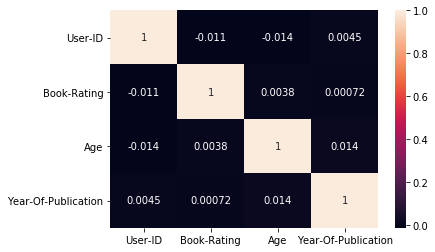

In [28]:
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Now I will determine the unique number of entries that will make up the training and test data sets

In [32]:
n_users = data['User-ID'].unique().shape[0]
n_books = data['ISBN'].unique().shape[0]
n_ratings = len(data)
avg_ratings_per_user = n_ratings/n_users

In [34]:
print('Number of unique users', n_users)
print('Number of unique books', n_books)
print('Total number of ratings', n_ratings)
print('Average number of ratings per user', avg_ratings_per_user)

Number of unique users 92106
Number of unique books 270151
Total number of ratings 1031136
Average number of ratings per user 11.195101296332487
